In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:
shape = X_train.shape[1]

In [3]:
from tensorflow.keras import layers, losses, regularizers, optimizers
import tensorflow as tf

model = tf.keras.Sequential([
    layers.Dense(shape, activation="swish", use_bias=False),
    layers.Dense(1024, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),  
    layers.Dense(1024, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(), # 因子标准化
    layers.Dense(256, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(0.002)),
])

model.compile(optimizer=optimizers.Adam(0.0003), loss="mse", metrics=["mae", "mape"])

history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), batch_size=256
)
model.save('dnn')

Epoch 1/20
2360/2360 [==============================] - 108s 45ms/step - loss: 2.9579 - mae: 0.7252 - mape: 1425.4269 - val_loss: 1.5621 - val_mae: 0.7089 - val_mape: 3482.8113
Epoch 2/20
2360/2360 [==============================] - 102s 43ms/step - loss: 1.1775 - mae: 0.7060 - mape: 1173.6897 - val_loss: 0.9853 - val_mae: 0.7099 - val_mape: 768.5295
Epoch 3/20
2360/2360 [==============================] - 104s 44ms/step - loss: 0.9175 - mae: 0.7030 - mape: 421.5476 - val_loss: 0.9048 - val_mae: 0.7111 - val_mape: 1296.9457
Epoch 4/20
2360/2360 [==============================] - 103s 44ms/step - loss: 0.8881 - mae: 0.7029 - mape: 490.8458 - val_loss: 0.9014 - val_mae: 0.7086 - val_mape: 1097.3221
Epoch 5/20
2360/2360 [==============================] - 104s 44ms/step - loss: 0.8863 - mae: 0.7028 - mape: 367.6496 - val_loss: 0.8996 - val_mae: 0.7092 - val_mape: 766.2588
Epoch 6/20
2360/2360 [==============================] - 104s 44ms/step - loss: 0.8867 - mae: 0.7028 - mape: 349.8351 - v

INFO:tensorflow:Assets written to: dnn\assets


INFO:tensorflow:Assets written to: dnn\assets


In [4]:
import pandas as pd
import scutquant.scutquant as q

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

8808/8808 [==============================] - 37s 4ms/step


,predict
count,281840.000000
mean,-0.000153
std,0.001818
min,-0.017292
25%,-0.000984
50%,0.000071
75%,0.000862
max,0.012559


In [5]:
y_test.describe()

count    281840.000000
mean          0.000463
std           0.024988
min          -0.100000
25%          -0.012383
50%           0.000000
75%           0.011458
max           0.100000
Name: label, dtype: float64

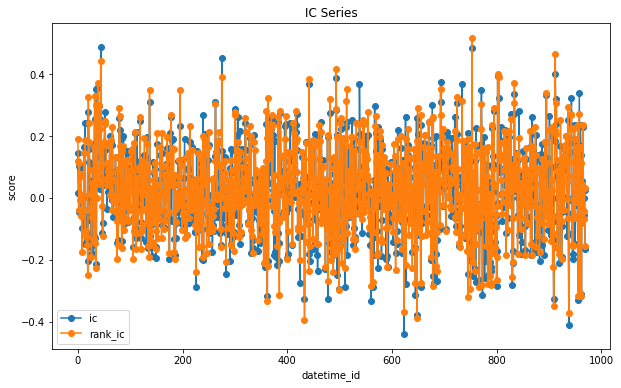

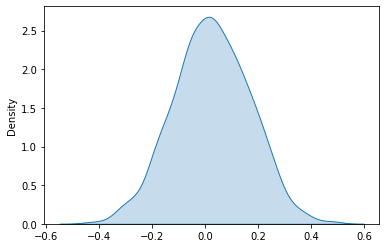

ic= 0.02414737338326726 icir= 0.167472761152817 rank_ic= 0.030321917462552826 rank_icir= 0.21096312339075587


0.024611818536323365

In [6]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

Accuracy of Prediction: 0.5283347430220409


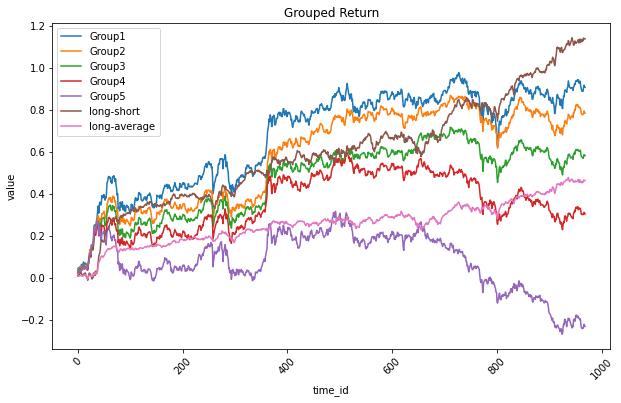

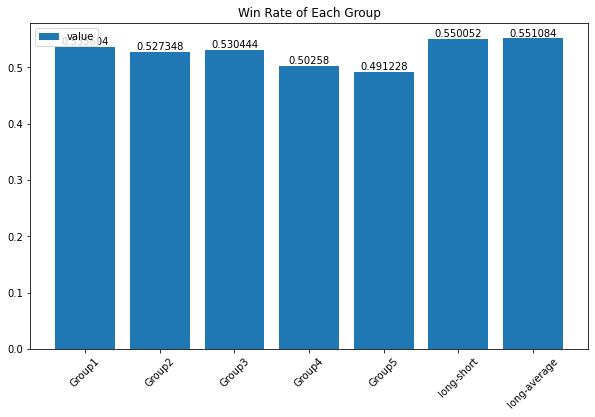

In [7]:
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='close', volume='vol')
report.group_return_ana(pred, y_test)

In [8]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%且值大于0.5%的股票, 做空后20%且值小于0.5%的股票. 自动平仓
        "kwargs": {
            "sigma": 1,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.5  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

Annualized Return: 0.15536980311656867
Annualized Volatility: 0.5179435855550062
Annualized Return(Benchmark): 0.08018445873901148
Annualized Volatility(Benchmark): 0.34119674516789367 

Cumulative Rate of Return: 0.7425178152193335
Cumulative Rate of Return(Benchmark): 0.3452639230000001
Cumulative Excess Rate of Return: 0.3972538922193334 

Max Drawdown: -0.4084073616387671
Max Drawdown(Benchmark): -0.541086994 

Sharpe Ratio: 1.9651951775455465
Sortino Ratio: 0.5007134371720947
Information Ratio: 0.37235230259737156 

Beta: 1.2205661323689192
Alpha: 0.005535539282879198
Epsilon: 0.15704225287897494
Profitable Days(%): 0.6625386996904025


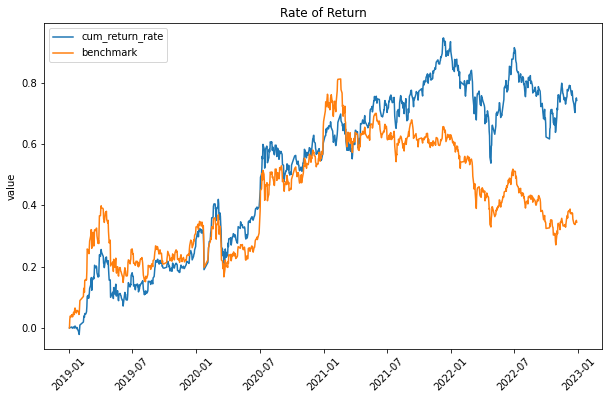

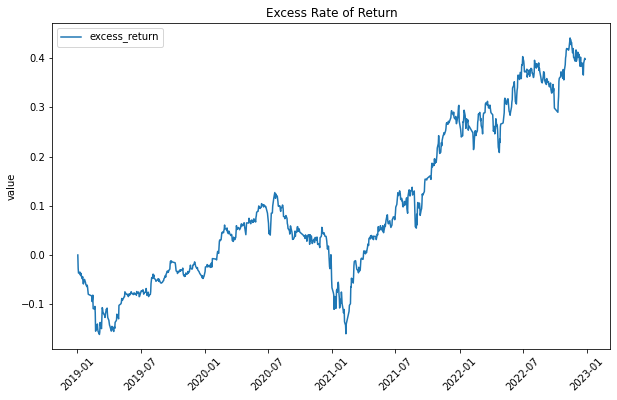

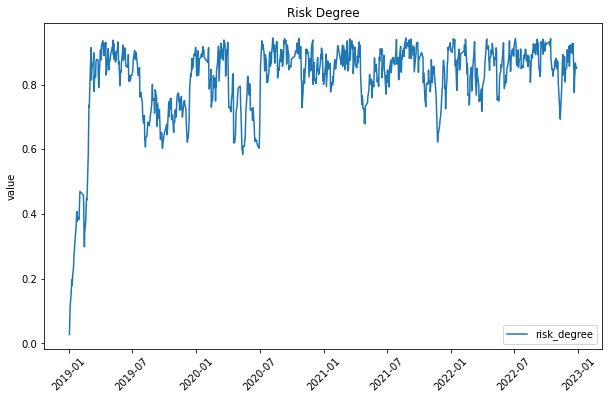

In [9]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节